In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

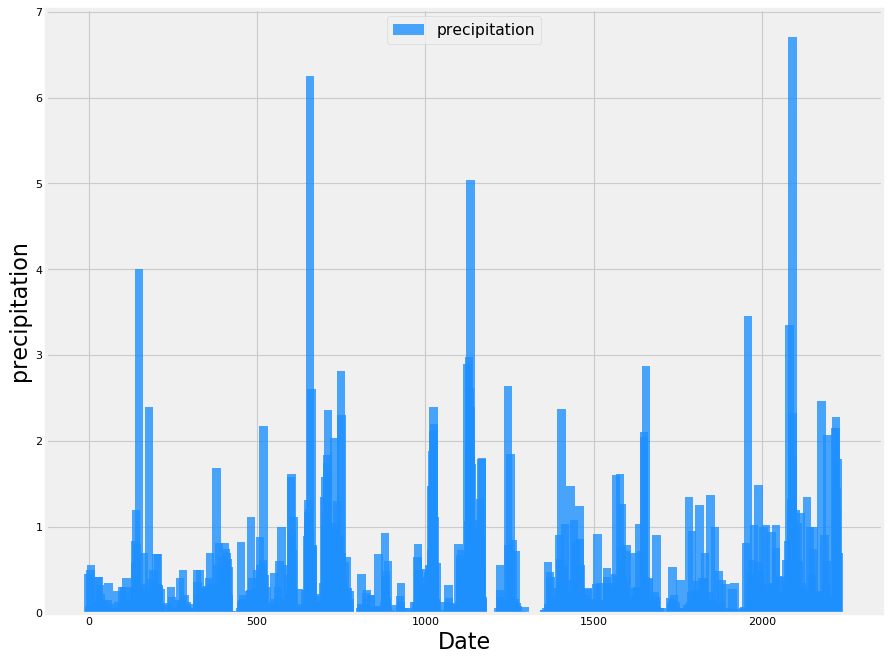

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
from datetime import datetime, timedelta

# Calculate the date 1 year ago from the last data point in the database
ymd_end = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).first()[0]
ymd_sobj = datetime.strptime(ymd_end + ' 0:0:0.0', '%Y-%m-%d  %H:%M:%S.%f') - timedelta(days=365)
ymd_start = str(ymd_sobj).split()[0]

# Perform a query to retrieve the data and precipitation scores
rows = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date.between(ymd_start, ymd_end)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(rows, columns=['Date', 'Prcp'])

# Sort the dataframe by date
df = df.sort_values(by='Date', ascending=False)
#df1 = df.groupby('Date')['Prcp'].sum().reset_index()
x_axis = np.arange(len(df['Date']))
plt.figure(figsize=(12, 10), dpi=80)
plt.bar(x_axis, df['Prcp'], color="dodgerblue", alpha=0.8, width=25.0, align="center")
plt.xlabel("Date", fontsize=20)
plt.ylabel("precipitation", fontsize=20)
plt.legend(["precipitation"], loc='upper center', fontsize=14)
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df1 = pd.DataFrame({"Precipitions": [df['Prcp'].count(), df['Prcp'].mean(), df['Prcp'].max(), df['Prcp'].std(), \
                                    df['Prcp'].quantile(0.25), df['Prcp'].quantile(0.50), df['Prcp'].quantile(0.75), \
                                    df['Prcp'].min() ],
                    "name": [ 'count', 'mean', 'max', 'std', '25%', '50%', '75%', 'min']})
df1.set_index(['name'], inplace = True, drop = True)
del df1.index.name 
df1

,Precipitions
count,2021.000000
mean,0.177279
max,6.700000
std,0.461190
25%,0.000000
50%,0.020000
75%,0.130000
min,0.000000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
from sqlalchemy import func
sorted_stataions = session.query(Measurement.station, \
  func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
sorted_stataions

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
most_active = sorted_stataions[0][0]
most_active

'USC00519281'

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = sorted_stataions[0][0]
from sqlalchemy import func
max_tobs = session.query(Measurement.tobs). \
 filter(Measurement.station==most_active).order_by(Measurement.tobs.desc()).first()[0]
max_tobs
min_tobs = session.query(Measurement.tobs). \
 filter(Measurement.station==most_active).order_by(Measurement.tobs.asc()).first()[0]
min_tobs
avg_tobs = session.query(func.avg(Measurement.tobs)).filter(Measurement.station==most_active).all()[0][0]
avg_tobs
print(f' highest Tosb={max_tobs},  lowest Tobs={min_tobs}, average Tobs={avg_tobs} ')


 highest Tosb=85.0,  lowest Tobs=54.0, average Tobs=71.66378066378067 


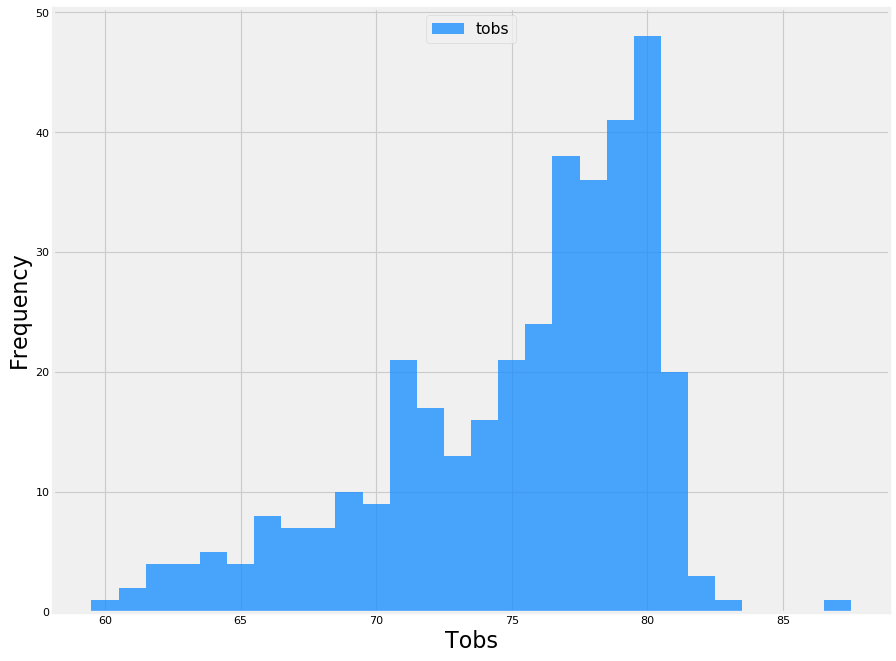

2017-08-23   2016-08-23


In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
st_hightest_tobs = session.query(Measurement.station,Measurement.tobs).order_by(Measurement.tobs.desc()).first()[0]
st_hightest_tobs
ymde = session.query(Measurement.date, Measurement.station, Measurement.tobs). \
        filter(Measurement.station==st_hightest_tobs).order_by(Measurement.date.desc()).first()[0]
ymds = str(datetime.strptime(ymde + ' 0:0:0.0', '%Y-%m-%d  %H:%M:%S.%f') - timedelta(days=365)).split()[0]
rows = session.query(Measurement.tobs, func.count(Measurement.tobs) ).filter(Measurement.station==st_hightest_tobs). \
                   filter(Measurement.date.between(ymds, ymde)).group_by(Measurement.tobs).all()
rows
df = pd.DataFrame(rows, columns=['Tobs', 'Frequency'])
x_axis = np.arange(len(df['Tobs']))
plt.figure(figsize=(12, 10), dpi=80)
plt.bar(df['Tobs'], df['Frequency'], color="dodgerblue", alpha=0.8, width=1.0, align="center")
plt.xlabel("Tobs", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.legend(["tobs"], loc='upper center', fontsize=14)
plt.show()
print(ymde, " " , ymds)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
calc_temps("2016-08-28", "2017-08-23")

[(58.0, 74.53163404642694, 87.0)]

In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
T = calc_temps("2016-08-23", "2017-08-23")
T

[(58.0, 74.59058295964125, 87.0)]

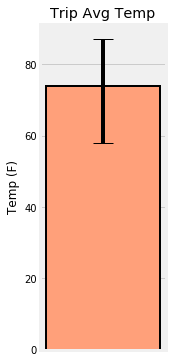

In [20]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Tmin, Tavg, Tmax  =  int(T[0][0]), int(T[0][1]), int(T[0][2]) 
Tavg, Tmin, Tmax
x=[1]
y=[Tavg]
yerr_upper=[Tmax - Tavg]
yerr_lower=[Tavg - Tmin]
fig = plt.figure(figsize=(2,6))
ax = fig.add_subplot(111)
ax.bar(x,y,
        width=0.2,
        color='lightsalmon',
        edgecolor='k',
        yerr=[yerr_lower,yerr_upper],
        linewidth = 2,
        capsize=10)
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temp (F)')

ax.set_xticks([])
plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [22]:
from datetime import datetime, timedelta

# Calculate the date 1 year ago from the last data point in the database
# ---  ymde = session.query(Measurement.date, Measurement.station, Measurement.tobs). \
# ---      filter(Measurement.station==st_hightest_tobs).order_by(Measurement.date.desc()).first()[0]
ymde = session.query(Measurement.station, func.max(Measurement.date)). \
         group_by(Measurement.station).order_by(func.max(Measurement.date).asc()).first()[1]
ymds = str(datetime.strptime(ymde + ' 0:0:0.0', '%Y-%m-%d  %H:%M:%S.%f') - timedelta(days=365)).split()[0]

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
rows = session.query(*sel).filter(Measurement.date.between(ymds, ymde)).group_by(Measurement.station). \
                   order_by(func.sum(Measurement.prcp).desc()).all()
rows

#  -- find out the start date in record for each station
#   session.query(Measurement.station, func.min(Measurement.date)). \
#    group_by(Measurement.station).order_by(func.min(Measurement.date).asc()).all()

#  USC00519397   2010-01-01 -  2017-08-23
#  USC00513117   2010-01-01 -  2017-07-31
#  USC00514830   2010-03-01 -  2017-08-23 
#  USC00517948   2010-05-03 -  2017-08-23 
#  USC00518838   2010-01-01 -  2015-11-20
#  USC00519523   2010-01-01 -  2017-08-23
#  USC00519281   2010-01-01 -  2017-08-18
#  USC00511918   2010-01-01 -  2015-10-30
#  USC00516128   2010-01-01 -  2017-08-23

[('USC00516128',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  1344.1499999999958),
 ('USC00519281',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  723.1499999999997),
 ('USC00519523',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  461.7899999999999),
 ('USC00513117',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  422.18999999999954),
 ('USC00514830', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 357.93),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  128.97000000000074),
 ('USC00511918',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  70.92000000000009),
 ('USC00517948',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  33.389999999999965),
 ('USC00518838', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]

## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
import datetime as dt

# Set the start and end date of the trip
start_d = dt.date(2015, 1 ,31)
end_d = start_d + dt.timedelta(days=7)

# Use the start and end date to create a range of dates
drange = pd.date_range(start =start_d,  end = end_d)

# Stip off the year and save a list of %m-%d strings
y = str(start_d).split()[0].split('-')[0]
dlist = [ str(x).split()[0].split('-')[1] + '-' + str(x).split()[0].split('-')[2] for x in drange]
dlist
# Loop through the list of %m-%d strings and calculate the normals for each date
rlist = []
for d in dlist:
    rlist.append( daily_normals(d)[0] )
rlist

[(60.0, 68.47368421052632, 74.0),
 (56.0, 68.14035087719299, 78.0),
 (59.0, 68.85964912280701, 77.0),
 (58.0, 67.79661016949153, 77.0),
 (61.0, 68.14035087719299, 76.0),
 (59.0, 69.6842105263158, 80.0),
 (58.0, 70.38983050847457, 77.0),
 (60.0, 69.0, 77.0)]

In [25]:
tmin = [x[0] for x in rlist]
tavg = [x[1] for x in rlist]
tmax = [x[2] for x in rlist]
ddd = [ str(y)+'-'+i for i in dlist ]
ddd
data = { 'Date': ddd, 'tmin' : tmin, 'tavg':tavg,  'tmax': tmax }
df =  pd.DataFrame(data)
df.set_index('Date')

,tmin,tavg,tmax
Date,,,
2015-01-31,60.0,68.473684,74.0
2015-02-01,56.0,68.140351,78.0
2015-02-02,59.0,68.859649,77.0
2015-02-03,58.0,67.796610,77.0
2015-02-04,61.0,68.140351,76.0
2015-02-05,59.0,69.684211,80.0
2015-02-06,58.0,70.389831,77.0
2015-02-07,60.0,69.000000,77.0


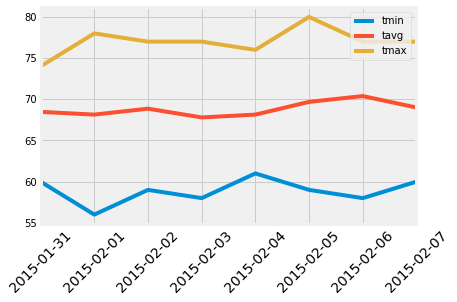

In [26]:
temp_chart = df.plot(kind='line')
plt.xticks(range(len(ddd)), ddd, rotation='45', fontsize='14')
plt.show()